# Train (Fine-tune) notebook

## Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import os

## Setting & Path

In [ ]:
DATA_ROOT = 'datasets/train'
VAL_ROOT = 'datasets/val'
MODEL_PTH = 'car_name_model.pth'  # Pre-trained model weight
NUM_CLASSES = 27
IMG_SIZE = (220, 165) # size of dataset images
EPOCHS = 6
BATCH_SIZE = 32
LR = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(DATA_ROOT, transform=train_transform)
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / (class_counts + 1e-8)
sample_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)

val_dataset = datasets.ImageFolder(VAL_ROOT, transform=train_transform) if os.path.exists(VAL_ROOT) else None
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) if val_dataset else None

model = models.resnet18(pretrained=False, num_classes=NUM_CLASSES)
state_dict = torch.load(MODEL_PTH, map_location=DEVICE)

model.load_state_dict(state_dict)

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## Train

In [23]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if (i+1) % 20 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Step {i+1} | Loss: {running_loss/20:.4f} | Acc: {100*correct/total:.1f}%")
            running_loss = 0.0

    if val_loader:
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        print(f"Epoch {epoch+1} | Val Acc: {val_correct/val_total:.2%}")

torch.save(model.state_dict(), 'car_model_finetuned.pth')
print("Finetuned weights saved at: car_model_finetuned.pth")

Epoch 1/6 | Step 20 | Loss: 3.2442 | Acc: 7.5%
Epoch 1/6 | Step 40 | Loss: 2.8171 | Acc: 16.2%
Epoch 1/6 | Step 60 | Loss: 2.4328 | Acc: 26.2%
Epoch 1/6 | Step 80 | Loss: 2.1187 | Acc: 36.6%
Epoch 1/6 | Step 100 | Loss: 1.8862 | Acc: 43.9%
Epoch 1/6 | Step 120 | Loss: 1.6340 | Acc: 49.8%
Epoch 1/6 | Step 140 | Loss: 1.4564 | Acc: 54.7%
Epoch 1/6 | Step 160 | Loss: 1.2869 | Acc: 58.4%
Epoch 1/6 | Step 180 | Loss: 1.2060 | Acc: 61.2%
Epoch 1/6 | Step 200 | Loss: 1.1109 | Acc: 63.5%
Epoch 1/6 | Step 220 | Loss: 0.9813 | Acc: 65.6%
Epoch 1/6 | Step 240 | Loss: 0.9895 | Acc: 67.2%
Epoch 1/6 | Step 260 | Loss: 0.8979 | Acc: 68.6%
Epoch 1/6 | Step 280 | Loss: 0.8005 | Acc: 70.0%
Epoch 1/6 | Step 300 | Loss: 0.8144 | Acc: 71.1%
Epoch 1/6 | Step 320 | Loss: 0.7907 | Acc: 71.9%
Epoch 1/6 | Step 340 | Loss: 0.7403 | Acc: 72.8%
Epoch 1/6 | Step 360 | Loss: 0.6625 | Acc: 73.6%
Epoch 1/6 | Step 380 | Loss: 0.7496 | Acc: 74.1%
Epoch 1/6 | Step 400 | Loss: 0.6215 | Acc: 74.8%
Epoch 1/6 | Step 420 | Lo

## Evaluate

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = train_dataset.classes

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=target_names, digits=3))

[[ 243    0    0    8    0    0    1    0    1    2    0    3    1    0
     0    6    0    0    0    0    0    0    0    0    0    0    2]
 [   0  119    1    1    0    0    0    0    0    0    0    0    0    0
     0    0    2    0    0    2    0    2    0    0    0    0    1]
 [   4    0  970    4    0    1    0    1    0    1    0    0    1    0
     0    0    0    1    0    5    0    1   14    1    2    0    1]
 [   4    0    1   58    0    1    0    0    0    0    0    1    0    0
     1    1    0    0    0    2    0    1    1    0    0    0    2]
 [   0    0    0    2  871    0    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    1]
 [   0    0    1    5    0  111    0    0    0    2    0    0    0    0
     0    0    0    3    0    0    1    4    1    0    0    0    2]
 [   2    0    0    0    1    0  873    0    0    0    0    1    0    0
     0    1    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision (macro):", precision_score(all_labels, all_preds, average='macro'))
print("Recall (macro):", recall_score(all_labels, all_preds, average='macro'))
print("F1 (macro):", f1_score(all_labels, all_preds, average='macro'))


Accuracy: 0.9699314499376818
Precision (macro): 0.8844069607888646
Recall (macro): 0.9361670722807696
F1 (macro): 0.9033185541147517


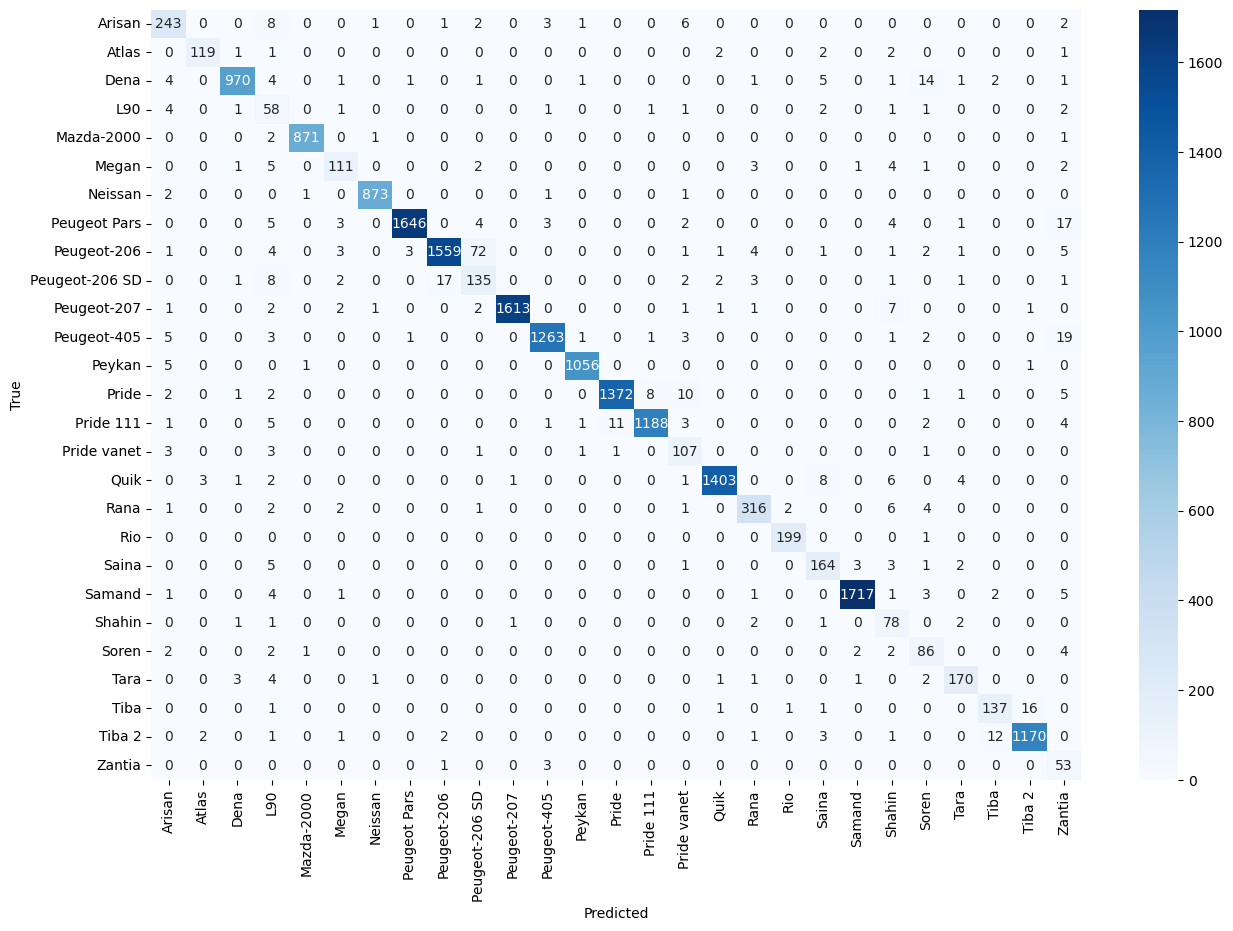

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


$$Github.com/RezaGooner$$